In [1]:
import os

from matplotlib import pyplot as plt
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
from torchvision import datasets, models, transforms
import torch
from functools import reduce
from typing import Union
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
%load_ext autoreload
%autoreload 2

In [2]:

### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = '../datasets' # PATH TO THE DATASET

# Number of threads for data loader
NUM_WORKERS = 4

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 224
N_CHANNELS = 3

# Number of classes in the dataset
NUM_CLASSES = 2

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 30

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 32

# Images mean and std channelwise
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 256

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device


device(type='cuda')

In [3]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      # converting to tensors
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0) if x.shape[0] == 1 else x),
    transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])

## Prepare data

In [4]:
caltech101 = torchvision.datasets.Caltech101(root=DATA_PATH, download=True, transform=transformer)#, transform=transformer)
torch.manual_seed(0)
train_dataset, val_dataset = torch.utils.data.random_split(caltech101, [7000, 1677])

caltech101_unchanged = torchvision.datasets.Caltech101(root=DATA_PATH, download=True)
torch.manual_seed(0)
train_dataset_unchanged, val_dataset_unchanged = torch.utils.data.random_split(caltech101_unchanged, [7000, 1677])

Files already downloaded and verified
Files already downloaded and verified


In [5]:
n_train, n_val = len(train_dataset), len(val_dataset)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

## Finetune VGG16

In [6]:
""" VGG16
    """
num_classes = 101
model_ft = models.vgg16(pretrained=True)
model_ft.classifier[6] = nn.Linear(model_ft.classifier[6].in_features, num_classes)
model_ft.to(device);

In [7]:
def compute_accuracy(model, val_loader):
    val_accuracy = []
    for X_batch, y_batch in val_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # compute logits
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))
    return val_accuracy
    
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            opt.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            opt.step()
            train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        val_accuracy += compute_accuracy(model, val_loader)

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_accuracy_value = np.mean(val_accuracy[-n_val // BATCH_SIZE :]) * 100
        
        print(f"  training loss (in-iteration): \t{train_loss_value:.6f}")
        print(f"  validation accuracy: \t\t\t{val_accuracy_value:.2f} %")

    return train_loss, val_accuracy

In [8]:
# optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# loss_fn = nn.CrossEntropyLoss()
# train_loss, val_accuracy = train_model(model_ft,
#                                          train_loader,
#                                          val_loader,
#                                          loss_fn,
#                                          optimizer_ft,
#                                          EPOCH_NUM)

In [9]:
#torch.save(model_ft.state_dict(), '../data/vgg16.pt')

# load model

num_classes = 101
model_ft = models.vgg16(pretrained=True)
model_ft.classifier[6] = nn.Linear(model_ft.classifier[6].in_features, num_classes)
model_ft.to(device);
model_ft.load_state_dict(torch.load('../data/vgg16.pt'))
model_ft.eval();


In [10]:
np.mean(compute_accuracy(model_ft, val_loader))*100

94.81585631349783

# Visualize nn

In [11]:
import sys
import nn_interpretability as nni
from nn_interpretability.interpretation.cam.grad_cam import GradCAMInterpreter

In [12]:
def get_module_by_name(module: Union[torch.Tensor, nn.Module],
                       access_string: str):
    """Retrieve a module nested in another by its access string.

    Works even when there is a Sequential in the module.
    """
    names = access_string.split(sep='.')
    return reduce(getattr, names, module)

## Visualize true predictions

In [49]:
import sys

sys.path.append(
    "/home/devel/ws.leonid/lectures/l5_visualization/vis_tools/pytorch_cnn_visualizations/src"
)

from nn_interpretability.interpretation.cam.grad_cam import GradCAMInterpreter
from itertools import product
from nn_interpretability.interpretation.backprop.guided_backprop import GuidedBackprop
from nn_interpretability.visualization.rgb_visualizer import RGBVisualizer

from nn_interpretability.interpretation.backprop.vanilla_backprop import VanillaBackprop
from nn_interpretability.interpretation.backprop.guided_backprop import GuidedBackprop
from nn_interpretability.interpretation.backprop.integrated_grad import IntegratedGrad
from nn_interpretability.interpretation.backprop.smooth_grad import SmoothGrad
from nn_interpretability.model.model_trainer import ModelTrainer
from nn_interpretability.model.model_repository import ModelRepository
from nn_interpretability.visualization.mnist_visualizer import MnistVisualizer
from nn_interpretability.dataset.mnist_data_loader import MnistDataLoader

from layercam import LayerCam
from gradcam import GradCam
from misc_functions import apply_colormap_on_image, apply_heatmap, convert_to_grayscale
from LRP import LRP
from matplotlib.colors import ListedColormap

from PIL import Image
import cv2
from pathlib import Path

def apply_heatmap(R):
    """
    Heatmap code stolen from https://git.tu-berlin.de/gmontavon/lrp-tutorial

    This is (so far) only used for LRP
    """
    b = 10 * ((np.abs(R) ** 3.0).mean() ** (1.0 / 3))
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:, 0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)

    # heatmap = plt.imshow(R, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    # plt.show()
    return my_cmap, b


def get_explanations(
    model,
    image_transformed: torch.tensor,
    image_unchanged: Image,
    image_category_name: str,
    image_category: int,
    save_path: Path
):

    image_shape = image_unchanged.size

    int_grad_steps = 20
    smooth_grad_samples = 100
    noise_level = 5
    num_row = 5
    num_col = 3

    fig, axs = plt.subplots(num_row, num_col, figsize=(10, 15))
    # set ticks to None
    for i, j in product(range(num_row), range(num_col)):
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

    # draw original image
    axs[0, 0].imshow(image_unchanged)
    axs[0, 0].set_title(f"input image: {image_category_name}")

    # gradcam on image

    grad_cam_extractor = GradCam(model_ft, target_layer=28)
    grad_cam = cv2.resize(
        grad_cam_extractor.generate_cam(image_transformed, target_class=image_category), image_shape
    )

    heatmap_grad_cam, heatmap_on_image_grad_cam = apply_colormap_on_image(
        image_unchanged, grad_cam, "hsv"
    )

    axs[0, 1].imshow(heatmap_on_image_grad_cam)
    axs[0, 1].set_title("GRAD-CAM on image")

    # gradcam
    axs[0, 2].imshow(heatmap_grad_cam)
    axs[0, 2].set_title("GRAD-CAM")

    # Vallina Backpropagation
    interpretor = VanillaBackprop(model, [], None)
    endpoint = interpretor.interpret(image_transformed, target_class = image_category)
    gray = convert_to_grayscale(endpoint.detach().numpy()[0])
    gray = gray - gray.min()
    gray /= gray.max()
    backprop_image = cv2.resize(
        gray[0], image_shape
    )
    
    axs[1, 0].imshow(backprop_image, interpolation="nearest")
    axs[1, 0].set_title("Vallina Backpropagation")

    # Guided Backpropagation
    interpretor = GuidedBackprop(model_ft, [], None)
    endpoint = interpretor.interpret(image_transformed, target_class = image_category)
    guided_backprop = RGBVisualizer.postprocess(endpoint)
    guided_backprop = cv2.resize(guided_backprop, image_shape)

    axs[1, 1].imshow(guided_backprop, interpolation="nearest")
    axs[1, 1].set_title("Guided Backpropagation ")

    # Integrated Gradients
    baseline = torch.zeros_like(image_transformed)
    interpretor = IntegratedGrad(model, [], None, baseline, steps=20)
    endpoint = interpretor.interpret(image_transformed)
    gray = convert_to_grayscale(endpoint.detach().numpy()[0])
    gray = gray - gray.min()
    gray /= gray.max()
    int_grad_image = cv2.resize(
        gray[0], image_shape
    )
    axs[1, 2].imshow(int_grad_image, interpolation="nearest")
    axs[1, 2].set_title("Integrated Gradients")

    # layer CAM. Layer 30

    layer_cam_extractor = LayerCam(model_ft, target_layer=30)
    layer_cam = cv2.resize(
        layer_cam_extractor.generate_cam(image_transformed, target_class=image_category), image_shape
    )

    heatmap_layer_cam, heatmap_on_image_layer_cam = apply_colormap_on_image(
        image_unchanged, layer_cam, "hsv"
    )

    axs[2, 0].imshow(heatmap_on_image_layer_cam)
    axs[2, 0].set_title("Layer-CAM(Layer 30) on image")

    axs[3, 0].imshow(heatmap_layer_cam)
    axs[3, 0].set_title("Layer-CAM(Layer 30)")

    # layer CAM. Layer 23

    layer_cam_extractor = LayerCam(model_ft, target_layer=23)
    layer_cam = cv2.resize(
        layer_cam_extractor.generate_cam(image_transformed, target_class=image_category), image_shape
    )

    heatmap_layer_cam, heatmap_on_image_layer_cam = apply_colormap_on_image(
        image_unchanged, layer_cam, "hsv"
    )

    axs[2, 1].imshow(heatmap_on_image_layer_cam)
    axs[2, 1].set_title("Layer-CAM(Layer 23) on image")

    axs[3, 1].imshow(heatmap_layer_cam)
    axs[3, 1].set_title("Layer-CAM(Layer 23)")

    # layer CAM. Layer 16

    layer_cam_extractor = LayerCam(model_ft, target_layer=16)
    layer_cam = cv2.resize(
        layer_cam_extractor.generate_cam(image_transformed, target_class=image_category), image_shape
    )

    heatmap_layer_cam, heatmap_on_image_layer_cam = apply_colormap_on_image(
        image_unchanged, layer_cam, "hsv"
    )

    axs[2, 2].imshow(heatmap_on_image_layer_cam)
    axs[2, 2].set_title("Layer-CAM(Layer 16) on image")

    axs[3, 2].imshow(heatmap_layer_cam)
    axs[3, 2].set_title("Layer-CAM(Layer 16)")

    # LRP. Layer 1
    layer = 1
    layerwise_relevance = LRP(model_ft)
    LRP_per_layer = layerwise_relevance.generate(
        image_transformed, target_class=image_category
    )

    # Convert the output nicely, selecting the first layer
    lrp_to_vis = np.array(LRP_per_layer[layer][0].cpu()).sum(axis=0)
    lrp_to_vis = np.array(
        Image.fromarray(lrp_to_vis).resize(
            (image_unchanged.size[0], image_unchanged.size[1]), Image.ANTIALIAS
        )
    )

    my_cmap, b = apply_heatmap(lrp_to_vis)
    axs[4, 0].imshow(lrp_to_vis, cmap=my_cmap, vmin=-b, vmax=b, interpolation="nearest")
    axs[4, 0].set_title(f"LRP(Layer {layer})")

    # LRP. Layer 7
    layer = 7
    layerwise_relevance = LRP(model_ft)
    LRP_per_layer = layerwise_relevance.generate(
        image_transformed, target_class=image_category
    )

    # Convert the output nicely, selecting the first layer
    lrp_to_vis = np.array(LRP_per_layer[layer][0].cpu()).sum(axis=0)
    lrp_to_vis = np.array(
        Image.fromarray(lrp_to_vis).resize(
            (image_unchanged.size[0], image_unchanged.size[1]), Image.ANTIALIAS
        )
    )

    my_cmap, b = apply_heatmap(lrp_to_vis)
    axs[4, 1].imshow(lrp_to_vis, cmap=my_cmap, vmin=-b, vmax=b, interpolation="nearest")
    axs[4, 1].set_title(f"LRP(Layer {layer})")

    # LRP. Layer 16
    layer = 16
    layerwise_relevance = LRP(model_ft)
    LRP_per_layer = layerwise_relevance.generate(
        image_transformed, target_class=image_category
    )

    # Convert the output nicely, selecting the first layer
    lrp_to_vis = np.array(LRP_per_layer[layer][0].cpu()).sum(axis=0)
    lrp_to_vis = np.array(
        Image.fromarray(lrp_to_vis).resize(
            (image_unchanged.size[0], image_unchanged.size[1]), Image.ANTIALIAS
        )
    )

    my_cmap, b = apply_heatmap(lrp_to_vis)
    axs[4, 2].imshow(lrp_to_vis, cmap=my_cmap, vmin=-b, vmax=b, interpolation="nearest")
    axs[4, 2].set_title(f"LRP(Layer {layer})")

    fig.tight_layout()
    save_path.parent.mkdir(exist_ok=True, parents=True)
    fig.savefig(save_path)


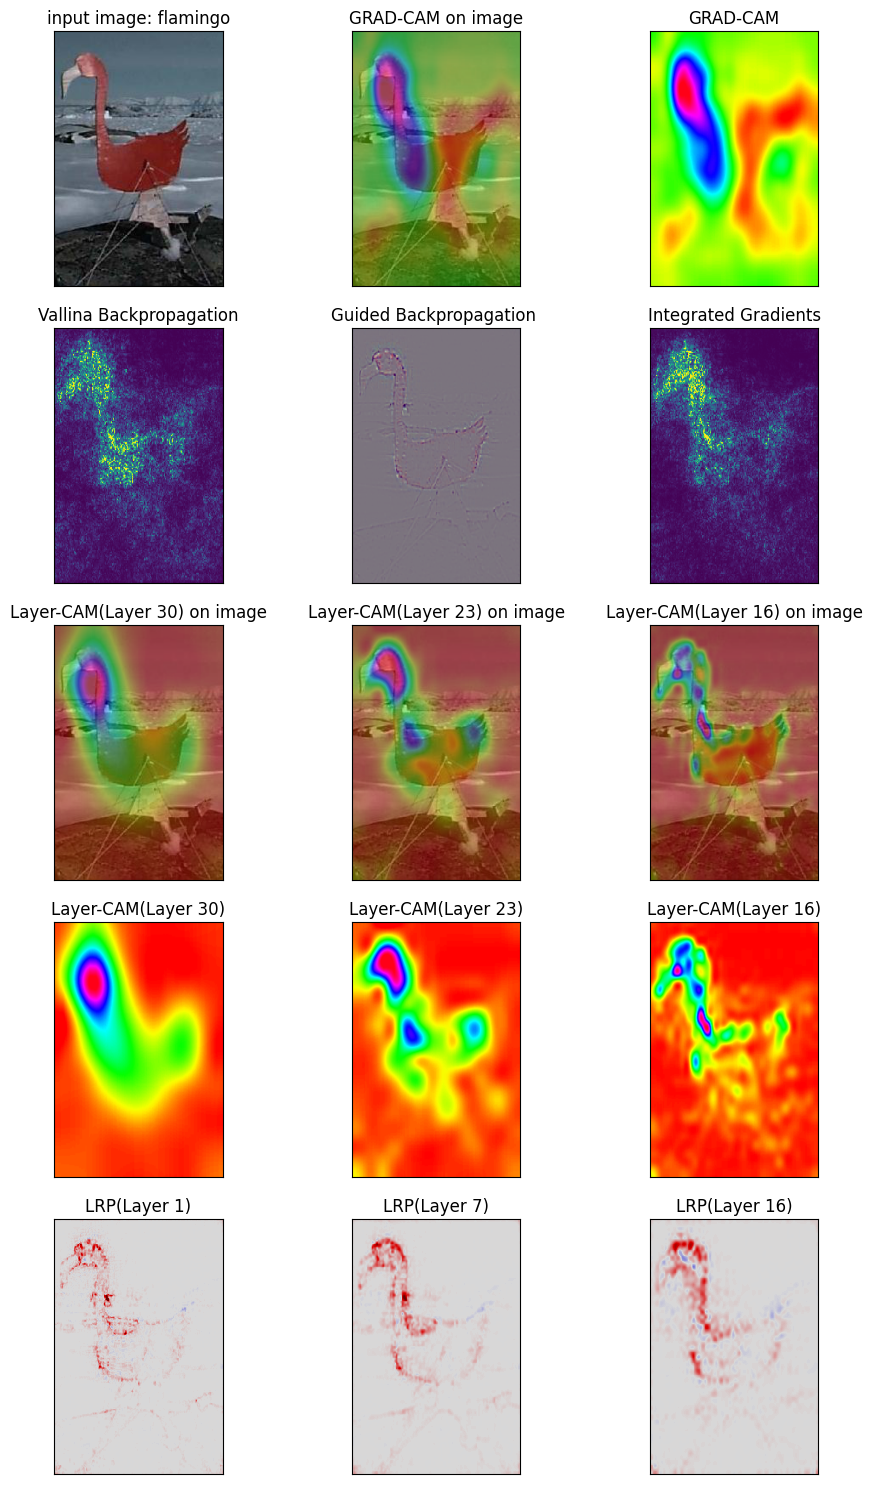

In [50]:
image_index = 44
image_unchanged, image_category = val_dataset_unchanged[image_index]
image_transformed = torch.unsqueeze(transformer(image_unchanged), 0).to(device)
get_explanations(model_ft, image_transformed, image_unchanged, caltech101.categories[image_category], image_category, Path('../outputs/test.png'))


# Visualize dataset

In [205]:
model_ft.eval()

for image_index in range(len(val_dataset_unchanged)):
    image_unchanged, image_category = val_dataset_unchanged[image_index]
    true_category_name = caltech101.categories[image_category]
    # prepare image
    image_transformed = torch.unsqueeze(transformer(image_unchanged), 0).to(device)
    # get class scores
    class_scores = model_ft(image_transformed)
    class_scores = class_scores.detach().cpu().numpy()[0]
    predicted_class = np.argmax(class_scores)

    if predicted_class == image_category:
        # right classified image. Save its visualization to foulder with class category name
        save_path = Path(
            f"../outputs/val/{true_category_name}_id{image_category}/{image_index}.png"
        )
        get_explanations(
            model_ft,
            image_transformed,
            image_unchanged,
            caltech101.categories[image_category],
            image_category,
            save_path,
        )
    else:
        
    #


In [206]:
image_category

23

# Inspect model architecture

In [21]:
# for module_pos, module in model_ft.features._modules.items():
#     print(module_pos, module)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
17 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 ReLU(inplace=True)
19 Conv2d(512, 512, kernel_size=(3, 3)

In [148]:
for module_pos, module in model_ft.classifier._modules.items():
    print(module_pos, module)

0 Linear(in_features=25088, out_features=4096, bias=True)
1 ReLU(inplace=True)
2 Dropout(p=0.5, inplace=False)
3 Linear(in_features=4096, out_features=4096, bias=True)
4 ReLU(inplace=True)
5 Dropout(p=0.5, inplace=False)
6 Linear(in_features=4096, out_features=101, bias=True)


In [164]:
summary(model_ft, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,